In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project 

/content/drive/MyDrive/Project


In [3]:
! pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00


In [4]:
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# **Split Dataset 1**

In [ ]:
! pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders # or import splitfolders
input_folder = "/content/drive/MyDrive/Project/dataset_coba"
output = "/content/drive/MyDrive/Project/dataset_coba2" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/drive/MyDrive/Project/dataset_coba2/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/drive/MyDrive/Project/dataset_coba2/val"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

Found 64 images belonging to 6 classes.
Found 16 images belonging to 6 classes.


# **Split Dataset 2**

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/Project/dataset_coba",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

val_data = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/Project/dataset_coba",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

Found 80 files belonging to 6 classes.
Using 64 files for training.
Found 80 files belonging to 6 classes.
Using 16 files for validation.


(32, 224, 224, 3)
Fauvism


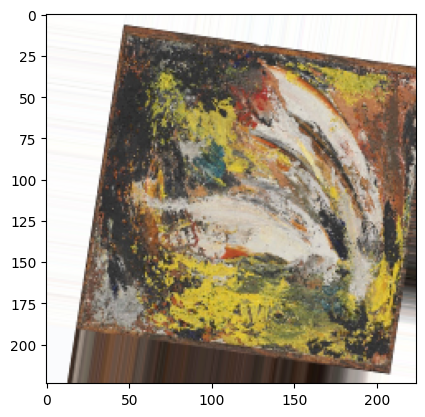

(32, 224, 224, 3)
Abstract


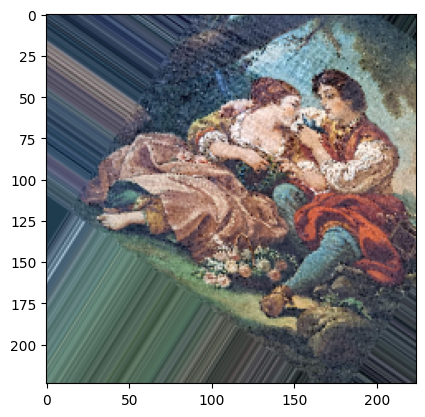

(32, 224, 224, 3)
Fauvism


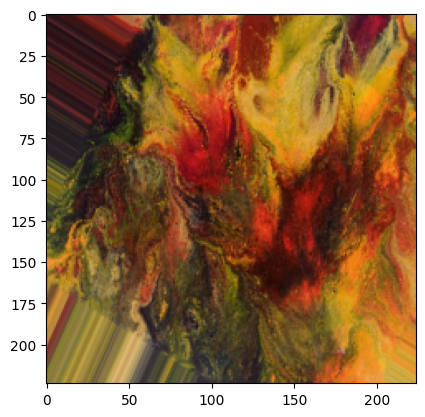

(32, 224, 224, 3)
Abstract


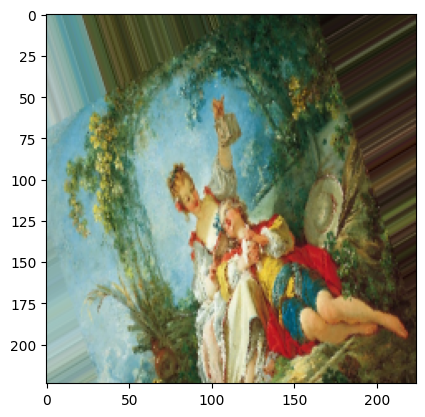

(32, 224, 224, 3)
Abstract


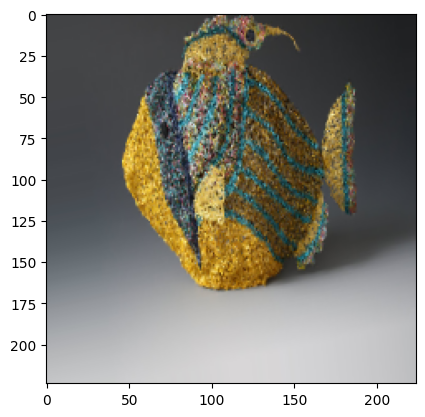

In [ ]:
import numpy as np
# Get the label to string mapping
label_to_str = {v: k for k, v in train_generator.class_indices.items()}

# Display some artworks
for _ in range(5):
    img, label = train_generator.next()
    random_index = np.random.randint(0, img.shape[0])
    image = img[random_index]
    image_label = label[random_index]
    print(img.shape) 
    plt.imshow(image)
    label_list = image_label.tolist()  
    print(label_to_str[label_list[0]])
    plt.show()

# **Model 1 (ResNet50V2)**

In [ ]:
# Load the Resnet50V2 pretrained model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = True

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
# Add extra layers to model
output = base_model.output

output = Flatten()(output)

output = Dense(256, kernel_initializer='he_uniform')(output)
output = Dropout(0.5)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(128, kernel_initializer='he_uniform')(output)
output = Dropout(0.25)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(64, kernel_initializer='he_uniform')(output)
output = Dropout(0.25)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(32, kernel_initializer='he_uniform')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(6, activation='softmax')(output)

model = Model(inputs=base_model.inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
adam = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc'])

In [ ]:
model.fit(train_generator, 
          validation_data=validation_generator,
          epochs=10)

Epoch 1/10
2/2 [==============================] - 87s 34s/step - loss: 1.2192 - accuracy: 0.6406 - val_loss: 6.0948 - val_accuracy: 0.0625
Epoch 2/10
2/2 [==============================] - 59s 27s/step - loss: 1.2951 - accuracy: 0.5781 - val_loss: 4.7197 - val_accuracy: 0.0625
Epoch 3/10
2/2 [==============================] - 72s 42s/step - loss: 1.2209 - accuracy: 0.6719 - val_loss: 3.9544 - val_accuracy: 0.1250
Epoch 4/10
2/2 [==============================] - 57s 27s/step - loss: 1.0938 - accuracy: 0.6406 - val_loss: 3.7890 - val_accuracy: 0.1250
Epoch 5/10
2/2 [==============================] - 56s 27s/step - loss: 1.0971 - accuracy: 0.6875 - val_loss: 3.6719 - val_accuracy: 0.1250
Epoch 6/10
2/2 [==============================] - 63s 29s/step - loss: 1.1559 - accuracy: 0.6719 - val_loss: 3.5498 - val_accuracy: 0.1250
Epoch 7/10
2/2 [==============================] - 56s 27s/step - loss: 0.9538 - accuracy: 0.8281 - val_loss: 3.3239 - val_accuracy: 0.1250
Epoch 8/10
2/2 [===========

# **Model 2**

In [ ]:
import tensorflow as tf

model2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 256x256 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(6, activation='softmax')
])

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 26, 26, 128)    

In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model2.fit(train_generator, 
          validation_data=validation_generator,
          epochs = 10,
          shuffle=True,
          verbose=1)

Epoch 1/10
2/2 [==============================] - 23s 11s/step - loss: 1.6682 - accuracy: 0.2344 - val_loss: 3.6466 - val_accuracy: 0.2500
Epoch 2/10
2/2 [==============================] - 20s 8s/step - loss: 2.3632 - accuracy: 0.2969 - val_loss: 1.6737 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 20s 9s/step - loss: 1.6452 - accuracy: 0.2500 - val_loss: 1.5653 - val_accuracy: 0.2500
Epoch 4/10
2/2 [==============================] - 20s 7s/step - loss: 1.5545 - accuracy: 0.2500 - val_loss: 1.5107 - val_accuracy: 0.1875
Epoch 5/10
2/2 [==============================] - 23s 11s/step - loss: 1.6298 - accuracy: 0.2188 - val_loss: 1.4713 - val_accuracy: 0.2500
Epoch 6/10
2/2 [==============================] - 20s 8s/step - loss: 1.4047 - accuracy: 0.3750 - val_loss: 1.3548 - val_accuracy: 0.3125
Epoch 7/10
2/2 [==============================] - 21s 9s/step - loss: 2.9808 - accuracy: 0.2969 - val_loss: 1.4782 - val_accuracy: 0.2500
Epoch 8/10
2/2 [================

# **Model 3 (ResNet50V2)**

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

In [ ]:
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(6)

In [ ]:
model3 = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

In [ ]:
model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [ ]:
model3.fit(train_data, 
          validation_data=val_data,
          epochs=10)

# **Model 4**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Rescaling, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model4 = Sequential([
  Rescaling(1./255, input_shape=(224, 224, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(6, activation='softmax')
])

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model4.fit(train_data, 
          validation_data=val_data,
          epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 [==============================] - 7s 2s/step - loss: 3.2176 - accuracy: 0.2344 - val_loss: 4.6434 - val_accuracy: 0.2500
Epoch 2/10
2/2 [==============================] - 8s 3s/step - loss: 4.0792 - accuracy: 0.2500 - val_loss: 3.0063 - val_accuracy: 0.3125
Epoch 3/10
2/2 [==============================] - 6s 2s/step - loss: 2.6007 - accuracy: 0.2344 - val_loss: 1.8571 - val_accuracy: 0.3125
Epoch 4/10
2/2 [==============================] - 7s 2s/step - loss: 1.5105 - accuracy: 0.3438 - val_loss: 1.7492 - val_accuracy: 0.2500
Epoch 5/10
2/2 [==============================] - 8s 4s/step - loss: 1.4544 - accuracy: 0.4062 - val_loss: 1.6000 - val_accuracy: 0.3125
Epoch 6/10
2/2 [==============================] - 6s 2s/step - loss: 1.2894 - accuracy: 0.3438 - val_loss: 1.3923 - val_accuracy: 0.3125
Epoch 7/10
2/2 [==============================] - 6s 2s/step - loss: 1.1377 - accuracy: 0.5781 - val_loss: 1.3164 - val_accuracy: 0.3750
Epoch 8/10
2/2 [==============================] - 6s

# **Model 5 (FIX) (ya okela)**

In [ ]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (224,224,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(6)   #Adding the Output Layer
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(learning_rate=0.001)
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [ ]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model5.fit(train_data, 
          validation_data=val_data,
          epochs=20)

Epoch 1/20
2/2 [==============================] - 9s 3s/step - loss: 1.6423 - accuracy: 0.2188 - val_loss: 1.5076 - val_accuracy: 0.3125
Epoch 2/20
2/2 [==============================] - 6s 2s/step - loss: 1.4337 - accuracy: 0.2656 - val_loss: 1.3933 - val_accuracy: 0.1250
Epoch 3/20
2/2 [==============================] - 8s 2s/step - loss: 1.3620 - accuracy: 0.3594 - val_loss: 1.3790 - val_accuracy: 0.2500
Epoch 4/20
2/2 [==============================] - 6s 2s/step - loss: 1.3385 - accuracy: 0.2656 - val_loss: 1.4471 - val_accuracy: 0.1250
Epoch 5/20
2/2 [==============================] - 6s 2s/step - loss: 1.2511 - accuracy: 0.3438 - val_loss: 1.3657 - val_accuracy: 0.3125
Epoch 6/20
2/2 [==============================] - 6s 2s/step - loss: 1.1840 - accuracy: 0.4062 - val_loss: 1.3002 - val_accuracy: 0.3125
Epoch 7/20
2/2 [==============================] - 8s 2s/step - loss: 1.1314 - accuracy: 0.5000 - val_loss: 1.3161 - val_accuracy: 0.3125
Epoch 8/20
2/2 [=========================

In [ ]:
model5.save('/content/drive/MyDrive/Project/Saved_model5')

In [5]:
from tensorflow import keras
model5 = keras.models.load_model('/content/drive/MyDrive/Project/Saved_model5')

# **Model 6**

In [ ]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape = (224,224,3)),
    tf.keras.layers.Conv2D(16,(3,3), padding='same', activation = "relu") ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), padding='same', activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), padding='same', activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), padding='same', activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(6, activation='softmax')   #Adding the Output Layer
])

In [ ]:
model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model6.fit(train_data, 
          validation_data=val_data,
          epochs=20)

Epoch 1/20
2/2 [==============================] - 10s 5s/step - loss: 1.6375 - accuracy: 0.2031 - val_loss: 1.5608 - val_accuracy: 0.3125
Epoch 2/20
2/2 [==============================] - 6s 2s/step - loss: 1.4415 - accuracy: 0.2812 - val_loss: 1.4003 - val_accuracy: 0.1250
Epoch 3/20
2/2 [==============================] - 8s 3s/step - loss: 1.3140 - accuracy: 0.3281 - val_loss: 1.3299 - val_accuracy: 0.6250
Epoch 4/20
2/2 [==============================] - 7s 3s/step - loss: 1.2319 - accuracy: 0.5625 - val_loss: 1.4439 - val_accuracy: 0.3125
Epoch 5/20
2/2 [==============================] - 6s 2s/step - loss: 1.1915 - accuracy: 0.4219 - val_loss: 1.3662 - val_accuracy: 0.2500
Epoch 6/20
2/2 [==============================] - 8s 2s/step - loss: 1.1204 - accuracy: 0.5469 - val_loss: 1.2307 - val_accuracy: 0.3750
Epoch 7/20
2/2 [==============================] - 6s 2s/step - loss: 0.9451 - accuracy: 0.6719 - val_loss: 1.1339 - val_accuracy: 0.6250
Epoch 8/20
2/2 [========================

In [ ]:
model6.save('/content/drive/MyDrive/Project/Saved_model')

In [ ]:
from tensorflow import keras
model6 = keras.models.load_model('/content/drive/MyDrive/Project/Saved_model')

# **Model 7 (InceptionResNetV2) (ini oke tapi ga realistis)**

In [ ]:
def get_defined_label(x):
    label_dict = {0:'Abstract', 1:'Fauvism', 2:'Fiber Art', 3:'Japanese', 4:'Pop Art', 5:'Romanticism'}
    for key, value in label_dict:
        if key == x:
            return value

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

base_model = InceptionResNetV2(
        input_shape=(224,224,3),
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
base_model.trainable = False

In [ ]:
print('Base Model Ouput Shape = {}'.format(base_model.output_shape))
last_output = base_model.output

Base Model Ouput Shape = (None, 1536)


In [ ]:
x = tf.keras.layers.Dropout(0.2)(last_output)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=6, activation='softmax')(x)

In [ ]:
model7 = tf.keras.Model( base_model.input, x) 

In [ ]:
model7.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002, momentum=0.9, centered=True), 
        loss = ['categorical_crossentropy'], 
        metrics = ['accuracy']
    )

In [ ]:
learning_rate_reduction =[
    ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=1,
        verbose=1,
        factor=0.25,
        min_lr=0.000003),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0.001, 
        patience=5, 
        verbose=1,
        mode='auto', 
        baseline=None, 
        restore_best_weights=True)]

In [ ]:
history = model7.fit(
    train_generator, 
    epochs=10, 
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction]
    )

Epoch 1/10
2/2 [==============================] - 31s 16s/step - loss: 0.6968 - accuracy: 0.7500 - val_loss: 0.1282 - val_accuracy: 1.0000 - lr: 3.0000e-06
Epoch 2/10
2/2 [==============================] - 30s 14s/step - loss: 0.5618 - accuracy: 0.7812 - val_loss: 0.1268 - val_accuracy: 1.0000 - lr: 3.0000e-06
Epoch 3/10
2/2 [==============================] - 29s 15s/step - loss: 0.4458 - accuracy: 0.7812 - val_loss: 0.1252 - val_accuracy: 1.0000 - lr: 3.0000e-06
Epoch 4/10
2/2 [==============================] - 29s 14s/step - loss: 0.5249 - accuracy: 0.7969 - val_loss: 0.1236 - val_accuracy: 1.0000 - lr: 3.0000e-06
Epoch 5/10
2/2 [==============================] - 33s 16s/step - loss: 0.4735 - accuracy: 0.8438 - val_loss: 0.1220 - val_accuracy: 1.0000 - lr: 3.0000e-06
Epoch 6/10
2/2 [==============================] - 29s 15s/step - loss: 0.5129 - accuracy: 0.7969 - val_loss: 0.1204 - val_accuracy: 1.0000 - lr: 3.0000e-06
Epoch 7/10
2/2 [==============================] - 28s 14s/step -

In [ ]:
model7.save('/content/drive/MyDrive/Project/Saved_model7')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Project/Saved_model')

# **Export Model**

In [ ]:
RPS_SAVED_MODEL = "rps_saved_model"

In [ ]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 6)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-05-24 09:19:51.363685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')})
{'dense_2': TensorSpec(shape=(None, 6), dtype=tf.float32, name='dense_2')}


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)

converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
open("converted_modelnew.tflite", "wb").write(tflite_model)

218102556

In [ ]:
tflite_model_file = 'converted_modelnew.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

# **Image Classification**

In [11]:
#with model 5
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  #Upload image
  path = fn
  img = load_img(path, target_size=(224, 224))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  #Predict image
  images = np.vstack([x])
  classes = model5.predict(images, batch_size=32)
  print(fn)
  print(classes)

Saving 7c8f1f64b8e3b5948ef998cbc016ba59--arte-pop-photo-illustration-670185573.JPG to 7c8f1f64b8e3b5948ef998cbc016ba59--arte-pop-photo-illustration-670185573 (3).JPG
1/1 [==============================] - 0s 40ms/step
7c8f1f64b8e3b5948ef998cbc016ba59--arte-pop-photo-illustration-670185573.JPG
[[  9.495524  -59.679283    7.0038877 -58.864716   15.538116  -11.856337 ]]


In [12]:
classes[0]

array([  9.495524 , -59.679283 ,   7.0038877, -58.864716 ,  15.538116 ,
       -11.856337 ], dtype=float32)

In [13]:
np.argmax(classes[0])

4

Pop Art is: Popular (designed for a mass audience), Transient (short-term solution), Expendable (easily forgotten), Low cost, Mass produced, Young (aimed at youth), Witty, Sexy, Gimmicky, Glamorous, Big business


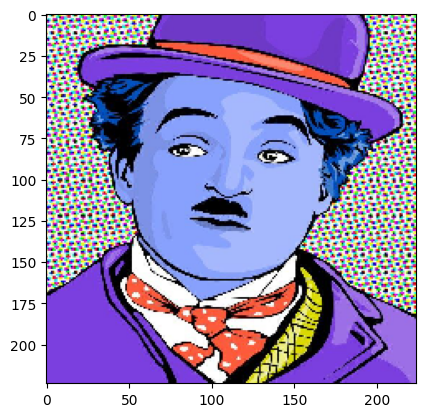

In [14]:
plt.imshow(img)
if(np.argmax(classes[0])) == 0:
  print("Abstract art is art that does not attempt to represent an accurate depiction of a visual reality but instead use shapes, colours, forms and gestural marks to achieve its effect")
elif(np.argmax(classes[0])) == 1:
  print("Fauvism is the name applied to the work produced by a group of artists (which included Henri Matisse and André Derain) from around 1905 to 1910, which is characterised by strong colours and fierce brushwork.")
elif(np.argmax(classes[0])) == 2:
  print("Fiber art is a style of fine art which uses textiles such as fabric, yarn, and natural and synthetic fibers. It focuses on the materials and on the manual labor involved as part of its significance.")
elif(np.argmax(classes[0])) == 3:
  print("Japanese Art: Art from Japan from the Muromachi period (1392-1573) all the way to the Shōwa period (1926-1989)")
elif(np.argmax(classes[0])) == 4:
  print("Pop Art is: Popular (designed for a mass audience), Transient (short-term solution), Expendable (easily forgotten), Low cost, Mass produced, Young (aimed at youth), Witty, Sexy, Gimmicky, Glamorous, Big business")
else:
  print("Romanticism: Romanticism (also the Romantic era or the Romantic period) was an artistic, literary, musical and intellectual movement that originated in Europe toward the end of the 18th century and in most areas was at its peak in the approximate period from 1800 to 1850. Romanticism was characterized by its emphasis on emotion and individualism as well as glorification of all the past and nature, preferring the medieval rather than the classical.")

# **Related Images**

In [ ]:
! pip install DeepImageSearch -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00


In [ ]:
! pip install DeepImageSearch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from DeepImageSearch import Load_Data, Search_Setup

In [ ]:
# Load images from a folder
image_list = Load_Data().from_folder(['/content/drive/MyDrive/Project/dataset_coba'])

In [ ]:
image_list[:5]

['/content/drive/MyDrive/Project/dataset_coba/Pop Art/wp1826801-1339271610.JPG',
 '/content/drive/MyDrive/Project/dataset_coba/Pop Art/ead00b89bcc79b14e9f3fef4d05622f1-3895394776.JPG',
 '/content/drive/MyDrive/Project/dataset_coba/Pop Art/vector-modern-pop-art-1750182720.JPG',
 '/content/drive/MyDrive/Project/dataset_coba/Pop Art/IMG_5744-686563894.JPG',
 '/content/drive/MyDrive/Project/dataset_coba/Pop Art/G3-Andy-Warhol2+copy-3941274838.JPG']

In [ ]:
# Set up the search engine, You can load 'vit_base_patch16_224_in21k', 'resnet50' etc more then 500+ models 
st = Search_Setup(image_list=image_list, model_name='vgg19', pretrained=True, image_count=100)

 Please Wait Model Is Loading or Downloading From Server!


 Model Loaded Successfully: vgg19


In [ ]:
# Index the images
st.run_index()

 Metadata and Features are already present, Do you want Extract Again? Enter yes or no
yes


100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


 Image Meta Information Saved: [metadata-files/vgg19/image_data_features.pkl]
 Saved The Indexed File:[metadata-files/vgg19/image_features_vectors.idx]


In [ ]:
# Get metadata
metadata = st.get_image_metadata_file()

In [ ]:
# Get similar images
st.get_similar_images(image_path='/content/drive/MyDrive/Project/dataset_coba/Abstract/6ryhn-1165693758.JPG', number_of_images=5)

{49: '/content/drive/MyDrive/Project/dataset_coba/Abstract/6ryhn-1165693758.JPG',
 42: '/content/drive/MyDrive/Project/dataset_coba/Abstract/b6be14328d7f6f28e5e8e64893a93549-859197344.JPG',
 44: '/content/drive/MyDrive/Project/dataset_coba/Abstract/7-598823407.JPG',
 55: '/content/drive/MyDrive/Project/dataset_coba/Abstract/pexels-photo-1070553-732578363.JPG',
 59: '/content/drive/MyDrive/Project/dataset_coba/Abstract/famous_abstract_art_painting_hd_2-1469201283 (1).jpg'}

In [ ]:
# Plot similar images
st.plot_similar_images(image_path='/content/drive/MyDrive/Project/dataset_coba/Abstract/04-women-expressionism-1349283850.JPG', number_of_images=5)

Output hidden; open in https://colab.research.google.com to view.